# Origen de Datos

In [238]:
#libreria a usar 
import numpy as np
import pandas as pd 
import pyodbc
import random

import seaborn as sns
from matplotlib.pyplot import plot




import warnings
warnings.filterwarnings('ignore')

In [239]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [240]:
#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT A.ID, 
		A.NOMBRE, 
		A.PROPOSITO,
		A.PUBLICO_OBJETIVO,
		B.DESCRIPCION AS TIPO_OFERTA_FORMATIVA,
		C.DESCRIPCION AS AREA_EDUCATIVA,
		D.DESCRIPCION AS NVEL_EDUCATIVO, 
		E.DESCRIPCION AS MODALIDAD_EDUCATIVA
	FROM [st].[SI_acfm.maestro.oferta_formativa] A
	LEFT JOIN [st].[SI_maestro.parametros] B ON A.TIPO_OFERTA_FORMATIVA = B.ID
	LEFT JOIN [st].[SI_maestro.parametros] C ON A.AREA_EDUCATIVA = C.ID
	LEFT JOIN [st].[SI_maestro.parametros] D ON A.NIVEL_EDUCATIVO = D.ID
	LEFT JOIN [st].[SI_maestro.parametros] E ON A.MODALIDAD_EDUCATIVA = E.ID
	WHERE A.ACTIVO = '1' AND B.DESCRIPCION = 'Curso'"""
oferta_formativa_df = pd.read_sql_query(query1,conn)



## interacciones del usuario con sifods
query2 = """SELECT ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS 
			FROM st.[SI_acfm.transaccional.oferta_formativa_accion] 
			WHERE FECHA_MODIFICACION IS NOT NULL"""
acciones_df = pd.read_sql_query(query2,conn)

## Participantes en los cursos de la oferta formativa
query3 = """SELECT ID_OFERTA_FORMATIVA, A.ID_PARTICIPANTE,CUMPLIMIENTO_ACTIVIDAD
			FROM [st].[SI_acfm.transaccional.oferta_formativa_curso_participante] A
			INNER JOIN (
						SELECT DISTINCT(ID_PARTICIPANTE),MAX(ID) AS LASTREG
						FROM [st].[SI_acfm.transaccional.oferta_formativa_curso_participante]
						GROUP BY ID_PARTICIPANTE) AS B ON A.ID=B.LASTREG
			WHERE CUMPLIMIENTO_ACTIVIDAD = 'COMPLETARON'"""
curso_participante_df = pd.read_sql_query(query3,conn)


## maestro de docentes inscritos en sifods
query4 = """SELECT ID,DNI,APELLIDO_PATERNO,APELLIDO_MATERNO,APELLIDO_CASADA,APELLIDO_MATERNO_CASADA,NOMBRES,PAIS_DOMICILIO,DEPARTAMENTO_DOMICILIO,PROVINCIA_DOMICILIO
			FROM [st].[SI_maestro.persona]"""
maestro_docentes_df = pd.read_sql_query(query4,conn)

#Cerrar la conexion
conn.close()

In [241]:
oferta_formativa_df.head(5)

,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,122,APRENDIZAJE A NIVEL REAL COMUNICACIÓN,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,Comunicación,None,EBR
1,116,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CO...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Comunicación,None,EBR
2,115,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO MA...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Matemática,None,EBR
3,117,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CI...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Ciencia y Tecnología,None,EBR
4,123,APRENDIZAJE A NIVEL REAL CIENCIA Y TECNOLOGÍA,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,Ciencia y Tecnología,None,EBR


In [242]:
acciones_df.head(5)

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS
0,78,06680611,False,5,0,0,0,0
1,79,99999999,False,6,0,0,0,0
2,80,99999999,False,3,0,0,0,0
3,81,99999999,False,12,0,0,0,0
4,84,99999999,False,9,0,0,0,0


# Manipulación de datos

In [243]:
#Conversion a mayusculas el nombre de la oferta formativa
oferta_formativa_df = oferta_formativa_df.apply(lambda x: x.astype(str).str.upper())

In [244]:
#Reduccion de ocurrencias de ID_OFERTA_FORMATIVA, DNI_DOCENTE
acciones_df = acciones_df.drop_duplicates(['ID_OFERTA_FORMATIVA','DNI_DOCENTE'],keep='last')
acciones_df.shape

(207470, 8)

# Selección de Variables
Se reviso las columnas de:
- Preferencia : Indica un "me gusta" en el curso
- Vistas : Contador de ingresos a los cursos
- Calificaciones : Numero de calificaciones que se da aun curso 
- Calificación : Puntuacion que se le asigna a un curso (las estrellas de que van de 0 a 5 )
- Compartir : Contador de la opcion compartir ( se puede compartir por facebook,linkedin, whatsapp, pinterest y twiter )
- Comentarios : Comentarios sobre el curso 

Los sistemas de recomendación se enfrentan al problema conocido como "arranque en frio", en el que es dificil proporcionar recomendaciones personalizadas a usuarios que no han consumido nada o muy poco
por ese motivo se excluiran a las personas con 0 vistas y con acciones en un solo curso

In [569]:
#Preferencia 
Porcentaje_preferencia=round((len(acciones_df[acciones_df['PREFERENCIA'] == 1]) / len(acciones_df) )* 100,1)
Porcentaje_vistas = round((len(acciones_df[acciones_df['VISTAS'] > 1]) / len(acciones_df)) * 100,1)
Porcentaje_calificaciones = round((len(acciones_df[acciones_df['CALIFICACIONES'] > 1]) / len(acciones_df)) * 100,1)
Porcentaje_califacion = round((len(acciones_df[acciones_df['CALIFICACION'] >0 ]) / len(acciones_df)) * 100,1)
Porcentaje_compartir = round((len(acciones_df[acciones_df['COMPARTIR'] >0 ]) / len(acciones_df)) * 100,1)
Porcentaje_comentarios = round((len(acciones_df[acciones_df['COMENTARIOS'] >0 ]) / len(acciones_df)) * 100,1)

print('Porcentaje de datos en la variable PREFERENCIA : ' + str(Porcentaje_preferencia) + '%')
print('Porcentaje de datos en la variable VISTAS : ' + str(Porcentaje_vistas) + '%')
print('Porcentaje de datos en la variable CALIFICACIONES : ' + str(Porcentaje_calificaciones) + '%')
print('Porcentaje de datos en la variable CALIFICACION : ' + str(Porcentaje_califacion) + '%')
print('Porcentaje de datos en la variable COMPARTIR : ' + str(Porcentaje_compartir) + '%')
print('Porcentaje de datos en la variable COMENTARIOS : ' + str(Porcentaje_comentarios) + '%')

Porcentaje de datos en la variable PREFERENCIA : 2.8%
Porcentaje de datos en la variable VISTAS : 99.6%
Porcentaje de datos en la variable CALIFICACIONES : 0.4%
Porcentaje de datos en la variable CALIFICACION : 1.0%
Porcentaje de datos en la variable COMPARTIR : 0.0%
Porcentaje de datos en la variable COMENTARIOS : 0.0%


In [570]:
acciones_df_count = acciones_df.groupby(['DNI_DOCENTE','ID_OFERTA_FORMATIVA']).size().groupby('DNI_DOCENTE').size()
print("# usuarios %d : " %len(acciones_df_count))
usuarios_con_interacciones = acciones_df_count[acciones_df_count >=2].reset_index()[['DNI_DOCENTE']]
print("# usuarios con mas de 2 interacciones %d : " % len(usuarios_con_interacciones))

# usuarios 86490 : 
# usuarios con mas de 2 interacciones 44480 : 


In [571]:
acciones_desde_acciones_df = acciones_df.merge(usuarios_con_interacciones, 
                            how = 'right',
                            left_on ='DNI_DOCENTE',
                            right_on ='DNI_DOCENTE')
print("# de interacciones con usuarios con mas de 2 interacciones en cursos: %d" %len(acciones_desde_acciones_df))

# de interacciones con usuarios con mas de 2 interacciones en cursos: 165460


In [572]:
 acciones_full_df = acciones_desde_acciones_df[['ID_OFERTA_FORMATIVA','DNI_DOCENTE','VISTAS']]
 acciones_full_df.head(3)

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS
0,232,00002741,26
1,196,00002741,2
2,242,00002741,9


In [573]:
acciones_full_df['Q'] = pd.qcut(acciones_full_df['VISTAS'], q=4, labels=False) +1

In [575]:
acciones_full_df.columns

Index(['ID_OFERTA_FORMATIVA', 'DNI_DOCENTE', 'VISTAS', 'Q'], dtype='object')

In [576]:
acciones_full_df= acciones_full_df.drop(['VISTAS'],axis=1)

In [577]:
len(acciones_full_df)

165460

# Evaluacion
Se utiliza el método de validación cruzada denomidado holdout, en el que una muestra aleatoria de datos se mantiene al margen del proceso de entrenamiento y se utiliza exclusivamente para la evaluación

In [578]:
from sklearn.model_selection import train_test_split
acciones_df_entrenamiento, acciones_df_prueba = train_test_split(acciones_full_df,stratify=acciones_full_df['DNI_DOCENTE'],test_size=0.3,random_state=29)

print("# de acciones en el dataset entrenamiento %d " %len(acciones_df_entrenamiento))
print("# de acciones en el dataset prueba %d" %len(acciones_df_prueba))


# de acciones en el dataset entrenamiento 115822 
# de acciones en el dataset prueba 49638


In [579]:
#indexación del DNI_Docente
acciones_df_indexed = acciones_full_df.set_index('DNI_DOCENTE')
acciones_df_entrenamiento_indexed = acciones_df_entrenamiento.set_index('DNI_DOCENTE')
acciones_df_prueba_indexed = acciones_df_prueba.set_index('DNI_DOCENTE')

In [580]:
def obtener_items_interactuados(dni, acciones_full_df):
    #Obtener los datos del usuario y fusionar la información 
    acciones_cursos = acciones_full_df.loc[dni]['ID_OFERTA_FORMATIVA']
    return set(acciones_cursos if type(acciones_cursos) == pd.Series else [acciones_cursos])

In [581]:
obtener_items_interactuados('10513427', acciones_df_indexed)

{145, 162, 173, 235, 240, 243}

In [582]:
acciones_full_df

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,Q
0,232,00002741,4
1,196,00002741,1
2,242,00002741,4
3,239,00006009,1
4,237,00006009,3
...,...,...,...
165455,81,99999999,4
165456,84,99999999,4
165457,83,99999999,3
165458,78,99999999,3


In [595]:
# Metricas de precisión TOP-N const
EVALUADOR_ALEATORIO_MUESTREO_NO_ACCIONES_ITEMS = 10

class EvaluacionModelo :

    def obtener_muestra_elementos_no_interactuados(self, dni, tamaño_muestra, seed=42):
        acciones_items = obtener_items_interactuados(dni, acciones_df_indexed)
        todos_items = set(oferta_formativa_df['ID'])
        items_no_interaccion = todos_items - acciones_items

        random.seed(seed)
        items_no_interacciones_muestra = random.sample( items_no_interaccion, tamaño_muestra)
        return set(items_no_interacciones_muestra)

    def _verificar_acierto_top_n(self, item_id, recomendador_oferta, topn) :
        try:
            index = next(i for i, c in enumerate(recomendador_oferta) if c == item_id)
        except :
            index = -1 
        acierto = int(index in range(0, topn))
        return acierto, index

    def evaluar_modelo_para_usuario(self, modelo, dni):
        #Obtener los elemntos del conjunto de prueba
        valores_acciones_prueba = acciones_df_prueba_indexed .loc[dni]
        if type(valores_acciones_prueba['ID_OFERTA_FORMATIVA']) == pd.Series:elementos_interactuados_por_persona = set(
            valores_acciones_prueba['ID_OFERTA_FORMATIVA'])
        else:
            elementos_interactuados_por_persona = set([int(valores_acciones_prueba['ID_OFERTA_FORMATIVA'])])
        contador_valores_acciones_prueba = len(elementos_interactuados_por_persona)

        #Obtención de una lista de recomendaciones clasificadas a partir de un modelo para un usuario determinado
        person_recs_df = modelo.recommend_items(dni, items_para_ignorar=obtener_items_interactuados(dni, acciones_df_entrenamiento_indexed ), topn=1000)

        acierto_para_5_contador = 0
        acierto_para_10_contador = 0
        #Para cada elementos con el que el usuario ha interactuado en el conjunto de pruebas
        for item_id in elementos_interactuados_por_persona : 
            #Obtención de una muestra aleatoria (100) de elementos con los que el usuario no ha interactuado 
            #Para presentar elementos que se supone que no son relevantes para el usuario
            items_no_interacciones_muestra = self.obtener_muestra_elementos_no_interactuados(dni,
                                                                                                tamaño_muestra=EVALUADOR_ALEATORIO_MUESTREO_NO_ACCIONES_ITEMS,
                                                                                                seed = item_id%(2**32))

            #Combinar el elemento interactuado actual con los 100 elementos aleatorios
            elementos_para_filtrar_recs = items_no_interacciones_muestra.union(set([item_id]))

            #Filtrar sólo las recomendaciones que son el elemento recomendado o de una muestra aleatoria de 100 elementos no interactuados
            valido_recs_df = person_recs_df[person_recs_df['ID_OFERTA_FORMATIVA'].isin(elementos_para_filtrar_recs)]
            valido_recs = valido_recs_df['ID_OFERTA_FORMATIVA'].values
            #Ccomprobacion de si el elemento interactuado se encuentra entre los N primeros elementos recomendados
            acierto_para_5, indice_para_5 = self._verificar_acierto_top_n(item_id, valido_recs, 5)
            acierto_para_5_contador += acierto_para_5
            acierto_para_10, indice_para_10 = self._verificar_acierto_top_n(item_id,valido_recs, 10)
            acierto_para_10_contador += indice_para_10

        #Recall es el porcentaje de elementos interactuado que se clasifican entre los N elementos recomendados
        #cuando se mezcla con un conjunto de datos no pertinentes
        recall_para_5 = acierto_para_5_contador / float(contador_valores_acciones_prueba)
        recall_para_10 = acierto_para_10_contador / float(contador_valores_acciones_prueba)

        metricas_persona =  { 'aciertos@5':acierto_para_5_contador,
                                'aciertos@10':acierto_para_10_contador,
                                'interacciones_cont': contador_valores_acciones_prueba,
                                'recall@5' : recall_para_5,
                                'recall@10' : recall_para_10}
        return metricas_persona



    def evaluar_modelo(self, modelo):
        personas_metricas = []
        for idx , dni in enumerate(list(acciones_df_prueba_indexed.index.unique().values)):
            # si idx % 100 == 0 and idx > 0:
            # print('%d users processed' % idx)
            metricas_persona = self.evaluar_modelo_para_usuario(modelo, dni)
            metricas_persona['DNI_DOCUMENTO'] = dni
            personas_metricas.append(metricas_persona)
        print('%d usuarios procesados' % idx)

        resultados_detallados_df = pd.DataFrame(personas_metricas)\
                                        .sort_values('interacciones_cont',ascending=False)

        global_recall_para_5 = resultados_detallados_df['aciertos@5'].sum() / float(resultados_detallados_df['interacciones_cont'].sum())
        global_recall_para_10 = resultados_detallados_df['aciertos@10'].sum() / float(resultados_detallados_df['interacciones_cont'].sum())

        metricas_globales = {'Modelo': modelo.get_model_name(),
                        'recall@5': global_recall_para_5,
                        'recall@10': global_recall_para_10}
        return metricas_globales, resultados_detallados_df

evaluador_modelo = EvaluacionModelo()

In [589]:
acciones_full_df

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,Q
0,232,00002741,4
1,196,00002741,1
2,242,00002741,4
3,239,00006009,1
4,237,00006009,3
...,...,...,...
165455,81,99999999,4
165456,84,99999999,4
165457,83,99999999,3
165458,78,99999999,3


## Modelo Popular
Un enfoque habitual es el modelo de popularidad, en realidad este modelo no es personalizado, sino que se limita a recomendar a un usuario los articulos más populares quye haya consumido anterioremente

In [590]:
#Calcular los curso mas populares de la oferta formativa
curso_popular_df = acciones_full_df.groupby('ID_OFERTA_FORMATIVA')['Q'].sum().sort_values(ascending=False).reset_index()
curso_popular_df.head(10)

,ID_OFERTA_FORMATIVA,Q
0,243,54297
1,232,26827
2,162,19166
3,231,18312
4,197,17564
5,196,14895
6,244,13865
7,235,10211
8,236,8819
9,199,8664


In [596]:
class RecomendadorPopular:

    MODEL_NAME = 'Popularidad'

    def __init__(self, popularidad_df, items_df=None):
        self.popularidad_df = popularidad_df
        self.items_df = items_df

    def get_model_name(self) :
        return self.MODEL_NAME

    def recommend_items(self, DNI_DOCENTE, items_para_ignorar=[], topn=5, verbose=False):
        # Recomienda los cursos más populares que el usuario no ha calificado
        recomendaciones_df = self.popularidad_df[~self.popularidad_df['ID_OFERTA_FORMATIVA'].isin(items_para_ignorar)] \
                                                                .sort_values('Q', ascending = False) \
                                                                .head(topn)
        if verbose :
            if self.items_df is None :
                raise Exception(' "items_df" is required in verbose mode')

            recomendaciones_df = recomendaciones_df.merge(self.items_df, how='left',
                                                            left_on='ID_OFERTA_FORMATIVA',
                                                            right_on = 'ID_OFERTA_FORMATIVA')

        return recomendaciones_df


modelo_popularidad = RecomendadorPopular(curso_popular_df, oferta_formativa_df)


In [597]:
print('Evaluar el modelo de recomendacion de popularidad...')
pop_metrica_global, pop_detalle_resultado_df = evaluador_modelo.evaluar_modelo(modelo_popularidad)
print('\nGlobal metrics:\n%s' % pop_metrica_global)
pop_detalle_resultado_df.head()


Evaluar el modelo de recomendacion de popularidad...
39558 usuarios procesados

Global metrics:
{'Modelo': 'Popularidad', 'recall@5': 0.9867440267536968, 'recall@10': 0.6932390507272654}


,aciertos@5,aciertos@10,interacciones_cont,recall@5,recall@10,DNI_DOCUMENTO
3566,20,21,21,0.952381,1.000000,44481918
75,18,46,20,0.900000,2.300000,48075981
985,15,46,19,0.789474,2.421053,18111213
2889,10,31,14,0.714286,2.214286,70321563
2101,12,18,14,0.857143,1.285714,19669484


## Modelo Basado en Contenido
el enfoque basado en contenido aprovecha la descripción o los atributos de los curos con los que ha interactuado el usuario para recomendar cursos similares

In [329]:
#Dataset de analisis
cursos_summary_df = oferta_formativa_df[['ID','PROPOSITO']]
print(cursos_summary_df)

      ID                                          PROPOSITO
0    122  FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...
1    116  FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...
2    115  FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...
3    117  FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...
4    123  FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...
..   ...                                                ...
124  145  EL CURSO VIRTUAL AUTOFORMATIVO, TRATAMIENTO CU...
125  161  ESTE CURSO VIRTUAL AUTOFORMATIVO PONE DE RELIE...
126  163  EL PROPÓSITO DE ESTE CURSO ES QUE LAS Y LOS DO...
127  232  ESTE CURSO VIRTUAL TIENE COMO PROPÓSITO FORTAL...
128  234  SU PROPÓSITO ES FORTALECER LAS COMPETENCIAS PR...

[129 rows x 2 columns]


In [331]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [333]:

stopwords_list = stopwords.words('spanish')

In [465]:
#mind_df = 5 , limita aquellas palabras clave que han ocurrido al menos cinco cursos
# max_df = 0.7 se excluyen las palabras que aparezcan en más del 70% de las descripciones
#stop_words lista de palabras vacias en Español
vectorizer = TfidfVectorizer(min_df=5,max_df=0.7,stop_words=stopwords_list)


item_ids = oferta_formativa_df['ID'].tolist()
tfidf_matrix = vectorizer.fit_transform(oferta_formativa_df['NOMBRE']+ "" + oferta_formativa_df['PROPOSITO'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix


<129x127 sparse matrix of type '<class 'numpy.float64'>'
	with 1772 stored elements in Compressed Sparse Row format>

In [476]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['ID_OFERTA_FORMATIVA'])

    user_item_calification = np.array(interactions_person_df['Q']).reshape(-1,1)
    #Media ponderada de los perfiles de los elementos según la fuerza de las interacciones
    user_item_calification_weighted_avg = np.sum(user_item_profiles.multiply(user_item_calification),axis=0) / np.sum(user_item_calification)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_calification_weighted_avg)
    return user_profile_norm

def build_users_profiles():
    interactions_indexed_df = acciones_df_entrenamiento [acciones_df_entrenamiento ['ID_OFERTA_FORMATIVA']\
                                                                 .isin(oferta_formativa_df['ID'].astype('int64'))].set_index('DNI_DOCENTE')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles


In [479]:
interactions_indexed_df = acciones_df_entrenamiento [acciones_df_entrenamiento ['ID_OFERTA_FORMATIVA']\
                                                                 .isin(oferta_formativa_df['ID'].astype('int64'))].set_index('DNI_DOCENTE')

In [484]:
oferta_formativa_df[oferta_formativa_df['ID']==202]

,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA


In [481]:
interactions_indexed_df[interactions_indexed_df['ID_OFERTA_FORMATIVA']==202]

,ID_OFERTA_FORMATIVA,Q
DNI_DOCENTE,,
05380076,202,3
10471359,202,4
15435784,202,3
25808666,202,1
29710153,202,1
...,...,...
72464381,202,3
29668897,202,4
20048510,202,1


In [477]:
user_profiles = build_users_profiles()
len(user_profiles)

ValueError: 202 is not in list

## Modelo de Filtrado Colaborativo

**Factorizacion Matricial**
Los modelos de factores latentes comprimen la matriz usuario-eleemento en una represetnacion de baja dimensión en términos de factores latentes. Una ventaja de utilizar este enfoque es que, en lugar de tener una matriz de alta dimensión que contenga un número abundante de valores perdidos, esteremos tratando con una matriz mucho más pequeña en un espacio de baja dimension.
Una presentación reducida podría utilizarse para algoritmos de vecindad basados en el usuario o en el item que se presentan en la sección anterior. Este paradigma presenta vrias ventajas. Maneja la escasez de la matriz original mejor que los basados en la memoria. Además, la comparación de similitudes en la matriz resultante es mucho más escalable, especialmente cuando se trata de grandes conjuntos de datos dispersos.

In [598]:
# Creación de una tabla dinámica dispersa con usuarios en filas y elementos en columnas
users_items_pivot_matrix_df = acciones_full_df.pivot(index='DNI_DOCENTE',
                                                        columns = 'ID_OFERTA_FORMATIVA',
                                                        values= 'Q').fillna(0)

users_items_pivot_matrix_df.head(5)

ID_OFERTA_FORMATIVA,1,2,3,4,5,6,7,8,9,10,...,245,246,248,249,250,251,252,253,293,294
DNI_DOCENTE,,,,,,,,,,,,,,,,,,,,,
00002741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00006009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00006226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000073850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00007462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [599]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [600]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['00002741',
 '00006009',
 '00006226',
 '000073850',
 '00007462',
 '00008538',
 '00010885',
 '00011708',
 '00012732',
 '00015535']

In [601]:
from scipy.sparse import csr_matrix
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<44480x203 sparse matrix of type '<class 'numpy.float64'>'
	with 165460 stored elements in Compressed Sparse Row format>

In [602]:
from scipy.sparse.linalg import svds
#The number of factors to factor the user-item matrix.
#NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix) #k = NUMBER_OF_FACTORS_MF)

In [603]:
U.shape

(44480, 6)

In [604]:
Vt.shape

(6, 203)

In [605]:
sigma = np.diag(sigma)
sigma.shape

(6, 6)

In [606]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 1.43839724e-03,  1.74937363e-04,  1.00690349e-03, ...,
         1.38226436e-04, -9.28303678e-04, -2.56739611e-04],
       [-2.09206605e-04, -7.75566616e-05,  5.16446709e-04, ...,
         5.07055086e-03,  8.86213075e-03,  1.26023221e-04],
       [ 1.39561415e-03,  1.46826405e-04,  9.84878520e-04, ...,
         1.90129231e-02,  3.53420008e-02,  9.91010333e-05],
       ...,
       [ 3.20095452e-04, -1.27921781e-06,  9.07821499e-04, ...,
        -1.87912968e-04,  4.26591121e-03, -3.49913434e-05],
       [ 1.82275041e-04,  1.85870927e-05,  1.99402338e-04, ...,
         8.86902712e-04,  2.90708610e-03, -7.94515024e-06],
       [ 6.66318724e-05,  6.22045586e-06,  6.55627380e-05, ...,
         4.26525524e-04,  1.24888540e-03,  4.09116403e-07]])

In [607]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [608]:
#Conversión de la matriz reconstruida en un marco de datos pandas
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,00002741,00006009,00006226,000073850,00007462,00008538,00010885,00011708,00012732,00015535,...,80670457,80670677,80684581,80684683,80685754,80685802,80685932,80688103,99999998,99999999
ID_OFERTA_FORMATIVA,,,,,,,,,,,,,,,,,,,,,
1,0.179502,0.179315,0.179497,0.179347,0.179363,0.179344,0.179359,0.179574,0.179318,0.179340,...,0.179508,0.179427,0.179366,0.179396,0.179582,0.179509,0.179673,0.179375,0.179360,0.179347
2,0.179359,0.179330,0.179356,0.179340,0.179341,0.179340,0.179341,0.179362,0.179334,0.179328,...,0.179350,0.179340,0.179342,0.179337,0.179358,0.179352,0.179370,0.179339,0.179341,0.179340
3,0.179453,0.179398,0.179451,0.179345,0.179362,0.179344,0.179358,0.179508,0.179368,0.179400,...,0.179510,0.179440,0.179366,0.179305,0.179624,0.179539,0.179777,0.179442,0.179362,0.179347
4,0.179402,0.179338,0.179432,0.179343,0.179357,0.179343,0.179353,0.179485,0.179336,0.179323,...,0.179466,0.179385,0.179358,0.179338,0.179520,0.179465,0.179594,0.179380,0.179355,0.179345
5,0.179414,0.179486,0.179397,0.179343,0.179355,0.179343,0.179351,0.179446,0.179421,0.179489,...,0.179489,0.179445,0.179358,0.179325,0.179568,0.179502,0.179751,0.179487,0.179355,0.179344
6,0.179492,0.179420,0.179542,0.179347,0.179374,0.179347,0.179367,0.179663,0.179377,0.179401,...,0.179586,0.179493,0.179378,0.179312,0.179717,0.179604,0.179935,0.179473,0.179372,0.179350
7,0.179397,0.179361,0.179413,0.179348,0.179371,0.179346,0.179362,0.179457,0.179347,0.179372,...,0.179615,0.179420,0.179371,0.179357,0.179727,0.179614,0.179819,0.179443,0.179366,0.179349
8,0.179397,0.179299,0.179428,0.179362,0.179419,0.179357,0.179392,0.179491,0.179316,0.179302,...,0.180083,0.179403,0.179415,0.179455,0.180302,0.180024,0.180435,0.179553,0.179402,0.179363
9,0.179350,0.179338,0.179375,0.179341,0.179345,0.179340,0.179343,0.179399,0.179336,0.179336,...,0.179379,0.179363,0.179344,0.179353,0.179385,0.179371,0.179393,0.179345,0.179343,0.179341


In [609]:
len(cf_preds_df.columns)

44480

In [610]:
cf_preds_df

,00002741,00006009,00006226,000073850,00007462,00008538,00010885,00011708,00012732,00015535,...,80670457,80670677,80684581,80684683,80685754,80685802,80685932,80688103,99999998,99999999
ID_OFERTA_FORMATIVA,,,,,,,,,,,,,,,,,,,,,
1,0.179502,0.179315,0.179497,0.179347,0.179363,0.179344,0.179359,0.179574,0.179318,0.179340,...,0.179508,0.179427,0.179366,0.179396,0.179582,0.179509,0.179673,0.179375,0.179360,0.179347
2,0.179359,0.179330,0.179356,0.179340,0.179341,0.179340,0.179341,0.179362,0.179334,0.179328,...,0.179350,0.179340,0.179342,0.179337,0.179358,0.179352,0.179370,0.179339,0.179341,0.179340
3,0.179453,0.179398,0.179451,0.179345,0.179362,0.179344,0.179358,0.179508,0.179368,0.179400,...,0.179510,0.179440,0.179366,0.179305,0.179624,0.179539,0.179777,0.179442,0.179362,0.179347
4,0.179402,0.179338,0.179432,0.179343,0.179357,0.179343,0.179353,0.179485,0.179336,0.179323,...,0.179466,0.179385,0.179358,0.179338,0.179520,0.179465,0.179594,0.179380,0.179355,0.179345
5,0.179414,0.179486,0.179397,0.179343,0.179355,0.179343,0.179351,0.179446,0.179421,0.179489,...,0.179489,0.179445,0.179358,0.179325,0.179568,0.179502,0.179751,0.179487,0.179355,0.179344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.169666,0.190304,0.204143,0.180156,0.181555,0.179628,0.181039,0.224292,0.181778,0.192219,...,0.189479,0.214264,0.181374,0.181767,0.190788,0.186971,0.185474,0.182062,0.180850,0.180123
252,0.179309,0.179354,0.179409,0.179340,0.179343,0.179340,0.179343,0.179459,0.179338,0.179347,...,0.179336,0.179421,0.179343,0.179312,0.179343,0.179340,0.179327,0.179332,0.179343,0.179341
253,0.179355,0.179913,0.181491,0.179385,0.179464,0.179351,0.179459,0.182981,0.179405,0.180021,...,0.179496,0.181733,0.179476,0.179294,0.179663,0.179519,0.179606,0.179318,0.179440,0.179387


In [611]:
class CFRecommender:
    
    MODEL_NAME = 'Filtrado Colaborativo'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_para_ignorar=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'PUN_PREDICT'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ID_OFERTA_FORMATIVA'].isin(items_para_ignorar)] \
                               .sort_values('PUN_PREDICT', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ID_OFERTA_FORMATIVA', 
                                                          right_on = 'ID')


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, oferta_formativa_df)

In [612]:
cf_preds_df.head(3)

,00002741,00006009,00006226,000073850,00007462,00008538,00010885,00011708,00012732,00015535,...,80670457,80670677,80684581,80684683,80685754,80685802,80685932,80688103,99999998,99999999
ID_OFERTA_FORMATIVA,,,,,,,,,,,,,,,,,,,,,
1,0.179502,0.179315,0.179497,0.179347,0.179363,0.179344,0.179359,0.179574,0.179318,0.179340,...,0.179508,0.179427,0.179366,0.179396,0.179582,0.179509,0.179673,0.179375,0.179360,0.179347
2,0.179359,0.179330,0.179356,0.179340,0.179341,0.179340,0.179341,0.179362,0.179334,0.179328,...,0.179350,0.179340,0.179342,0.179337,0.179358,0.179352,0.179370,0.179339,0.179341,0.179340
3,0.179453,0.179398,0.179451,0.179345,0.179362,0.179344,0.179358,0.179508,0.179368,0.179400,...,0.179510,0.179440,0.179366,0.179305,0.179624,0.179539,0.179777,0.179442,0.179362,0.179347


In [613]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = evaluador_modelo.evaluar_modelo(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
39558 usuarios procesados

Global metrics:
{'Modelo': 'Filtrado Colaborativo', 'recall@5': 0.9805793948184859, 'recall@10': 0.5051976308473347}


,aciertos@5,aciertos@10,interacciones_cont,recall@5,recall@10,DNI_DOCUMENTO
3566,21,19,21,1.000000,0.904762,44481918
75,18,43,20,0.900000,2.150000,48075981
985,16,41,19,0.842105,2.157895,18111213
2889,10,28,14,0.714286,2.000000,70321563
2101,13,20,14,0.928571,1.428571,19669484
120,12,13,13,0.923077,1.000000,06789783
1096,11,25,13,0.846154,1.923077,48628110
2619,12,0,12,1.000000,0.000000,43139017
479,12,3,12,1.000000,0.250000,43877671
6723,11,17,11,1.000000,1.545455,10234267


## Comparando los Metodos

In [619]:
cf_global_metrics

{'Modelo': 'Filtrado Colaborativo',
 'recall@5': 0.9805793948184859,
 'recall@10': 0.5051976308473347}

In [620]:
global_metrics_df = pd.DataFrame([pop_metrica_global,cf_global_metrics]) \
                                            .set_index('Modelo')
global_metrics_df

,recall@5,recall@10
Modelo,,
Popularidad,0.986744,0.693239
Filtrado Colaborativo,0.980579,0.505198


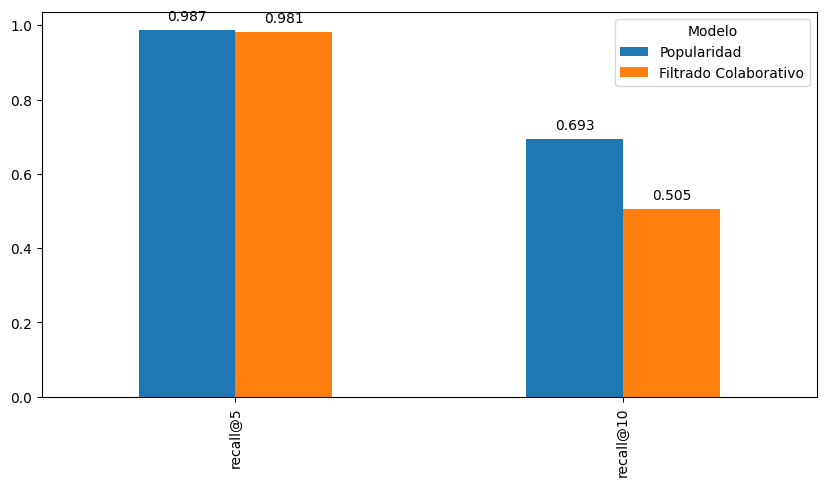

In [623]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(10,5))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [633]:
oferta_formativa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     129 non-null    int64 
 1   NOMBRE                 129 non-null    object
 2   PROPOSITO              129 non-null    object
 3   PUBLICO_OBJETIVO       129 non-null    object
 4   TIPO_OFERTA_FORMATIVA  129 non-null    object
 5   AREA_EDUCATIVA         129 non-null    object
 6   NVEL_EDUCATIVO         129 non-null    object
 7   MODALIDAD_EDUCATIVA    129 non-null    object
dtypes: int64(1), object(7)
memory usage: 8.2+ KB


In [634]:
acciones_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165460 entries, 0 to 165459
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID_OFERTA_FORMATIVA  165460 non-null  int64 
 1   DNI_DOCENTE          165460 non-null  object
 2   Q                    165460 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.8+ MB


## Testing

In [636]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = acciones_df_prueba_indexed
    else:
        interactions_df = acciones_df_entrenamiento_indexed
    return acciones_df_indexed.loc[person_id].merge(oferta_formativa_df, how = 'left', 
                                                      left_on = 'ID_OFERTA_FORMATIVA', 
                                                      right_on = 'ID') \
                          .sort_values('Q', ascending = False)

In [642]:
inspect_interactions('00002741', test_set=False).head(10)

,ID_OFERTA_FORMATIVA,Q,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,232,4,232.0,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,ESTE CURSO VIRTUAL TIENE COMO PROPÓSITO FORTAL...,DOCENTES DE EDUCACIÓN BÁSICA REGULAR DEL NIVEL...,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
2,242,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,196,1,196.0,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,TODAS,INICIAL,EDUCACIÓN BÁSICA REGULAR


**Recomendaciones**

In [647]:
#FiltroColaborativo= CFRecommender()
cf_recommender_model.recommend_items(user_id='00002741', topn=5, verbose=True)

,ID_OFERTA_FORMATIVA,PUN_PREDICT,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,232,0.561614,232,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,ESTE CURSO VIRTUAL TIENE COMO PROPÓSITO FORTAL...,DOCENTES DE EDUCACIÓN BÁSICA REGULAR DEL NIVEL...,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
1,231,0.288804,231,ESTRATEGIAS PARA EL DESARROLLO DE UNA CONVIVEN...,ESTE CURSO TIENE COMO PROPÓSITO FORTALECER LAS...,DOCENTES DE INSTITUCIONES EDUCATIVAS DE EDUCAC...,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA REGULAR
2,196,0.285080,196,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,TODAS,INICIAL,EDUCACIÓN BÁSICA REGULAR
3,198,0.228182,198,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,MATEMÁTICA,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
4,199,0.219715,199,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,ESTE CURSO VIRTUAL AUTOFORMATIVO TIENE COMO PR...,DOCENTES DE LA EDUCACIÓN BÁSICA.,CURSO,COMUNICACIÓN,SECUNDARIA,EDUCACIÓN BÁSICA REGULAR
